# Neural Networks
In this notebook we will learn how to train a simple Multilayer Perceptron for image classification using PyTorch. You can find additional information [here](https://pytorch.org/tutorials/beginner/basics/intro.html).

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load dataset

In [4]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations

data_aug = transforms.Compose([transforms.ToTensor()])  # the ToTensor transform scales the image into [0., 1.0] range
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
indices = list(range(len(validation_data)))
np.random.shuffle(indices)

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)


torch.Size([1, 28, 28])
5
torch.Size([64, 1, 28, 28])
tensor([4, 1, 6, 7, 7, 4, 9, 1, 0, 8, 3, 3, 0, 1, 8, 9, 7, 7, 9, 2, 0, 7, 9, 7,
        8, 7, 1, 4, 8, 3, 3, 5, 6, 2, 3, 8, 1, 0, 1, 5, 7, 1, 6, 7, 5, 2, 0, 3,
        6, 3, 9, 6, 5, 5, 3, 3, 7, 3, 7, 2, 0, 2, 6, 4])


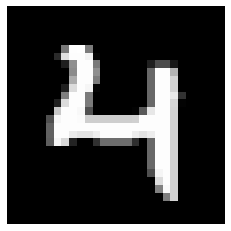

In [5]:
# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2  # how many processes are used to load the data\

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

# let's visualize the data
# alternative 1: using the Dataset
sample = training_data[0]
img = sample[0]
label = sample[1]
print(img.shape)  # note that here we only get one image and its label
print(label)

# alternative 2: iterate over the Dataloader
for batch in train_dataloader:
  imgs = batch[0]
  labels = batch[1]
  print(imgs.shape)
  print(labels)

  plt.imshow(imgs[0][0, :, :], cmap='gray')
  plt.axis('off')
  plt.show()
  
  break


## Defining the model

In [21]:
# Get cpu or gpu device for training.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)

        return logits


model = NeuralNetwork().to(device)  # put model in device (GPU or CPU)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Train the model

In [22]:
loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
      model.train()  # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item()  # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [30]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")
for t in range(num_epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
    val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["accuracy"].append(train_acc)

    val_history["loss"].append(val_loss)
    val_history["accuracy"].append(val_acc)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:05<00:00, 166.59it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 59.83it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 2


100%|██████████| 937/937 [00:05<00:00, 167.83it/s]


Train loss: 0.676 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 60.11it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 3


100%|██████████| 937/937 [00:05<00:00, 170.30it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 61.58it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 4


100%|██████████| 937/937 [00:05<00:00, 172.46it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 62.36it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 5


100%|██████████| 937/937 [00:05<00:00, 174.00it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:01<00:00, 64.70it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 6


100%|██████████| 937/937 [00:05<00:00, 170.74it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 60.36it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 7


100%|██████████| 937/937 [00:05<00:00, 169.10it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 60.07it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 8


100%|██████████| 937/937 [00:05<00:00, 158.12it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 59.47it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 9


100%|██████████| 937/937 [00:05<00:00, 160.11it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 56.63it/s] 


Val loss: 0.654 	 Val acc: 0.839

Epoch 10


100%|██████████| 937/937 [00:05<00:00, 166.31it/s]


Train loss: 0.675 	 Train acc: 0.835


100%|██████████| 125/125 [00:02<00:00, 58.82it/s] 

Val loss: 0.654 	 Val acc: 0.839
Finished


## Analyse training evolution

In [25]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

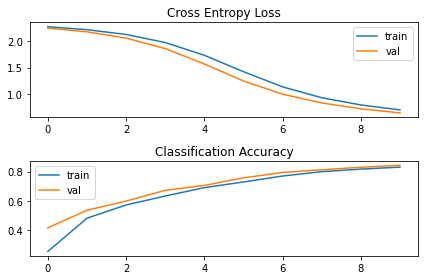

In [11]:
plotTrainingHistory(train_history, val_history)

## Test the model

In [26]:
# Evaluate the model in the test set

# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed

model = NeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:04<00:00, 486.62it/s]


Test Loss: 0.663 
Test Accuracy: 0.845


In [27]:
def showErrors(model, dataloader, num_examples=20):    
    plt.figure(figsize=(15, 15))

    for ind, (X, y) in enumerate(dataloader):
      if ind >= 20: break
      X, y = X.to(device), y.to(device)    
      pred = model(X)
      probs = F.softmax(pred, dim=1)
      final_pred = torch.argmax(probs, dim=1)

      plt.subplot(10, 10, ind + 1)
      plt.axis("off")
      plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
      plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
      plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
    plt.show()

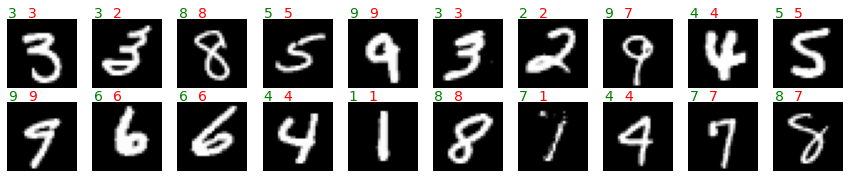

In [29]:
showErrors(model, test_dataloader)

## Additional Challenges

a) As the test accuracy should show, the MNIST dataset is not very challenging, change the code to use Fashion-MNIST and compare the results.

b) Do the same for the CIFAR10 (or CIFAR100) dataset. Note that, in this case, each image is a 32x32 color image; convert it to grayscale or concatenate the RGB channels in one single vector (e.g. using the reshape method).

c) The test accuracy for CIFAR is significantly worse. Try improving the results by using: 1) a deeper architecture, and 2) a different optmizer.

You can load the datasets from [here](https://pytorch.org/vision/stable/datasets.html).
